In [1]:
path = "data/raw_data/P03/"
# perfect: 3,4,5,6
# problems:
# - 1 wrong sequence sync
# - 2 wrong number of sequences->first should be excluded

**Schedule**

1. Load Isoforce data and extract torque segments.
2. Load Isoforce data recorded with Python and extract torque segments with time stamps.
3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data.
4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values.

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from tools import (
    IsoforceIso,
    IsoforcePy,
    ProcessingDir,
    Protocol,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

_1. Load Isoforce data and extract torque segments._

Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
[60 60 30 30 20 20 50 50 80 80 70 70 40 40]
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


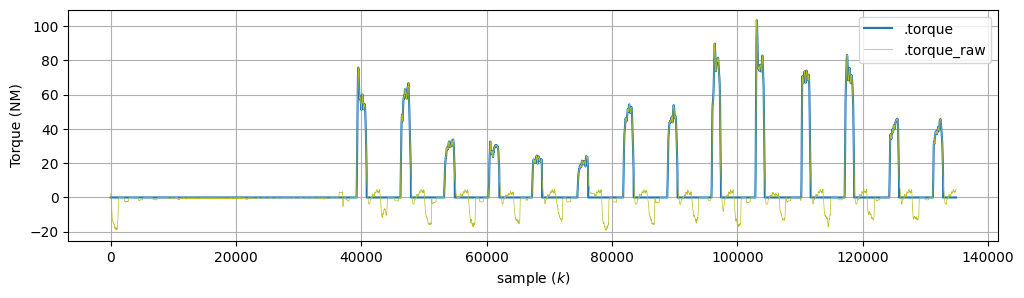

In [3]:
part_path = ProcessingDir(path)
protocol = Protocol(part_path.path, prints=False)
print(protocol.IsokinetikMeasurement.force_levels)

DF = renderDF(part_path.isoforce_iso)

isoforce_iso = IsoforceIso(DF, LP_filter=True)
isoforce_iso.plot_torque()

_2. Load Isoforce data recorded with Python and extract torque segments with time stamps._

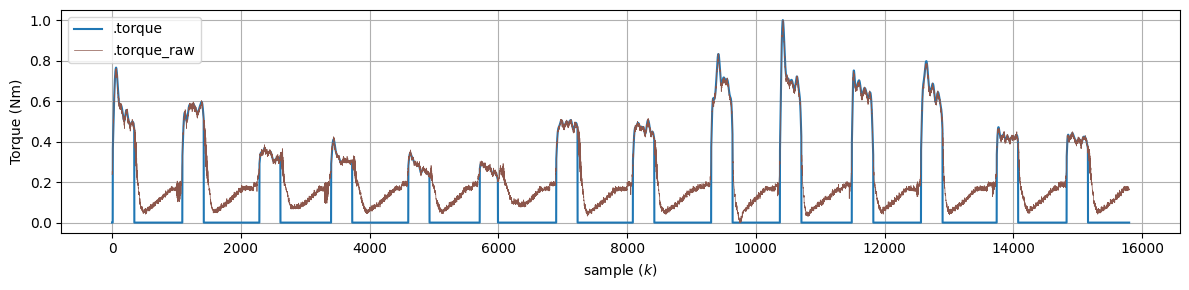

In [4]:
isoforce_py = IsoforcePy(
    part_path.isoforce_py_raw,
    protocol,
    LP_filter=True,
    over_UTC=False,
    scale_0_1=True,
)
isoforce_py.plot_torque()

In [5]:
# isoforce_py.torque_segments
# isoforce_py.timestamp_segments

_3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data._

In [6]:
assert len(isoforce_iso.torque_segments.keys()) == len(
    isoforce_py.torque_segments.keys()
)

In [7]:
print(isoforce_iso.torque_segments.keys())
print(isoforce_py.torque_segments.keys())
print(isoforce_py.timestamp_segments.keys())

dict_keys(['T_seg_0', 'T_seg_1', 'T_seg_2', 'T_seg_3', 'T_seg_4', 'T_seg_5', 'T_seg_6', 'T_seg_7', 'T_seg_8', 'T_seg_9', 'T_seg_10', 'T_seg_11', 'T_seg_12', 'T_seg_13'])
dict_keys(['T_seg_0', 'T_seg_1', 'T_seg_2', 'T_seg_3', 'T_seg_4', 'T_seg_5', 'T_seg_6', 'T_seg_7', 'T_seg_8', 'T_seg_9', 'T_seg_10', 'T_seg_11', 'T_seg_12', 'T_seg_13'])
dict_keys(['ts_seg_0', 'ts_seg_1', 'ts_seg_2', 'ts_seg_3', 'ts_seg_4', 'ts_seg_5', 'ts_seg_6', 'ts_seg_7', 'ts_seg_8', 'ts_seg_9', 'ts_seg_10', 'ts_seg_11', 'ts_seg_12', 'ts_seg_13'])


In [8]:
from tools import sync_NI_PY_times

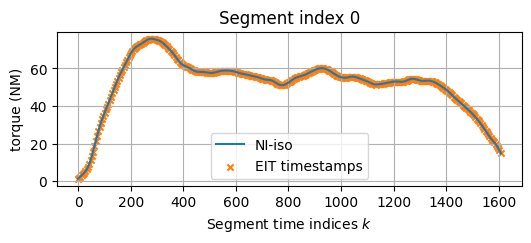

In [9]:
tmp_ts_seg, sampled_iso = sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx=0, plotting=True
)

_4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values._

In [10]:
from tools import find_best_match, find_closest_index, load_eit_npz

In [11]:
def sync_eit_ISO_segments(
    part_path, isoforce_iso, isoforce_py, mode="fast", plotting: bool = True
):
    eit_start_ts = 0
    EIT = list()
    TORQUE = list()
    TS_iso = list()
    TS_eit = list()

    print("Loading eit...")
    times_eit, eit = load_eit_npz(part_path)

    print("Matching sequences...")
    for seg_idx in range(len(isoforce_iso.torque_segments.keys())):
        tmp_ts_seg, sampled_iso = sync_NI_PY_times(
            isoforce_iso, isoforce_py, seg_idx, plotting
        )

        if mode == "fast":
            eit_start_ts = find_closest_index(times_eit, tmp_ts_seg[0])
            eit_stop_ts = find_closest_index(times_eit, tmp_ts_seg[-1])
            print(
                f"detected start idx values{tmp_ts_seg[0]=}, {times_eit[eit_start_ts]=}"
            )
            print(f"{eit_start_ts=}, {eit_stop_ts=}, diff:{eit_stop_ts-eit_start_ts}")
        elif mode == "slow":
            eit_start_ts, eit_start_distance = find_best_match(
                times_eit, tmp_ts_seg[:5]
            )
            print(
                f"Best match at index: {eit_start_ts}, DTW-distanz: {eit_start_distance}"
            )

        print(
            eit_start_ts,
            "diff start:",
            tmp_ts_seg[0] - times_eit[eit_start_ts],
            "diff end:",
            tmp_ts_seg[0 - 1] - times_eit[eit_start_ts + len(tmp_ts_seg)],
        )
        assert len(times_eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]) == len(
            tmp_ts_seg
        )

        # corresponding eit sequence:
        eit_sync_seq = eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]
        eit_ts_seq = times_eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]
        assert (
            len(eit_sync_seq) == len(tmp_ts_seg) == len(sampled_iso) == len(eit_ts_seq)
        )

        # plt.figure(figsize=(6, 2))
        # plt.title("err")
        # plt.plot(times_eit[eit_start_ts:eit_start_ts+len(tmp_ts_seg)]-tmp_ts_seg)
        # plt.show()

        EIT.append(eit_sync_seq)
        TORQUE.append(sampled_iso)
        TS_iso.append(tmp_ts_seg)
        TS_eit.append(eit_ts_seq)

    EIT = np.concatenate(EIT)
    TORQUE = np.concatenate(TORQUE)
    TS_iso = np.concatenate(TS_iso)
    TS_eit = np.concatenate(TS_eit)

    return EIT, TORQUE, TS_iso, TS_eit

Loading eit...
Matching sequences...


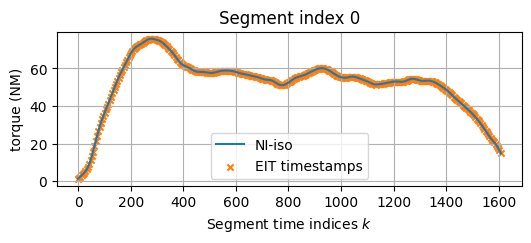

detected start idx valuestmp_ts_seg[0]=1739979143.1, times_eit[eit_start_ts]=1739979143.097
eit_start_ts=982, eit_stop_ts=1115, diff:133
982 diff start: 0.003000020980834961 diff end: -5.016000032424927


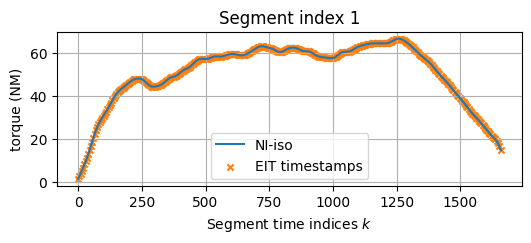

detected start idx valuestmp_ts_seg[0]=1739979195.91, times_eit[eit_start_ts]=1739979195.919
eit_start_ts=3095, eit_stop_ts=3227, diff:132
3095 diff start: -0.008999824523925781 diff end: -4.999000072479248


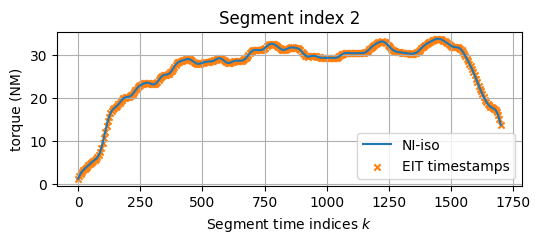

detected start idx valuestmp_ts_seg[0]=1739979249.88, times_eit[eit_start_ts]=1739979249.891
eit_start_ts=5254, eit_stop_ts=5384, diff:130
5254 diff start: -0.010999917984008789 diff end: -4.910999774932861


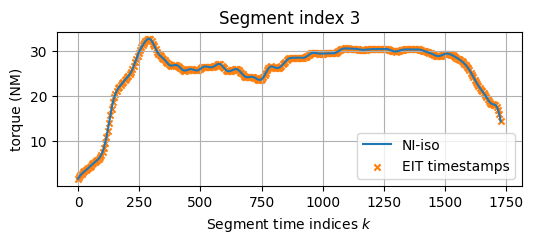

detected start idx valuestmp_ts_seg[0]=1739979302.02, times_eit[eit_start_ts]=1739979302.014
eit_start_ts=7339, eit_stop_ts=7470, diff:131
7339 diff start: 0.006000041961669922 diff end: -4.9079999923706055


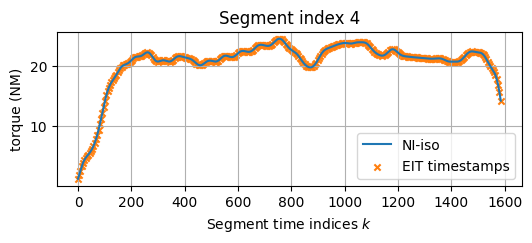

detected start idx valuestmp_ts_seg[0]=1739979356.01, times_eit[eit_start_ts]=1739979356.011
eit_start_ts=9499, eit_stop_ts=9630, diff:131
9499 diff start: -0.0009999275207519531 diff end: -4.944999933242798


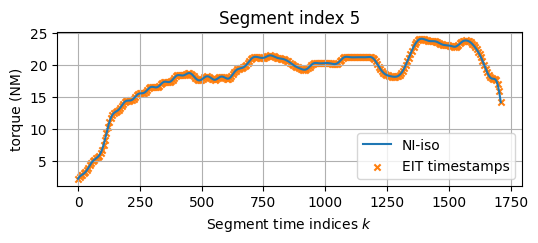

detected start idx valuestmp_ts_seg[0]=1739979415.11, times_eit[eit_start_ts]=1739979415.108
eit_start_ts=11863, eit_stop_ts=11976, diff:113
11863 diff start: 0.0019998550415039062 diff end: -4.236999988555908


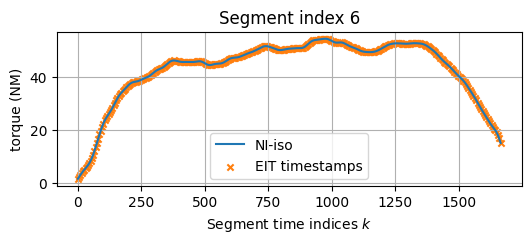

detected start idx valuestmp_ts_seg[0]=1739979468.99, times_eit[eit_start_ts]=1739979468.98
eit_start_ts=14018, eit_stop_ts=14150, diff:132
14018 diff start: 0.009999990463256836 diff end: -4.96399998664856


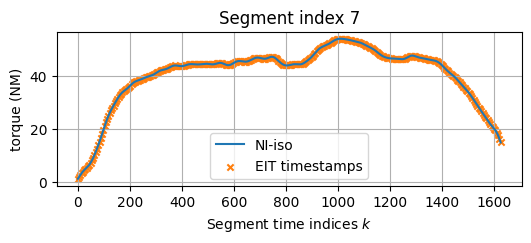

detected start idx valuestmp_ts_seg[0]=1739979526.9, times_eit[eit_start_ts]=1739979526.902
eit_start_ts=16335, eit_stop_ts=16467, diff:132
16335 diff start: -0.0019998550415039062 diff end: -4.990999937057495


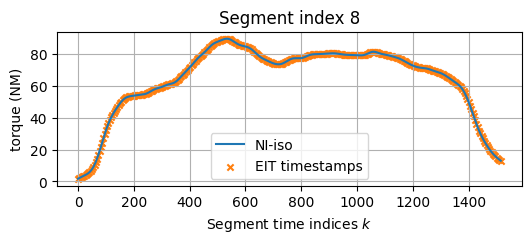

detected start idx valuestmp_ts_seg[0]=1739979586.06, times_eit[eit_start_ts]=1739979586.048
eit_start_ts=18701, eit_stop_ts=18834, diff:133
18701 diff start: 0.011999845504760742 diff end: -4.978000164031982


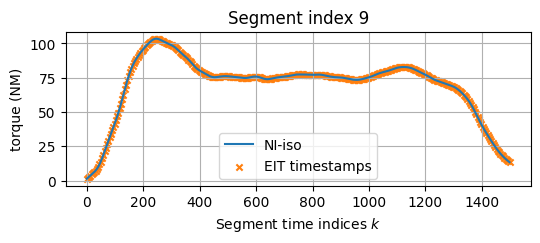

detected start idx valuestmp_ts_seg[0]=1739979643.74, times_eit[eit_start_ts]=1739979643.745
eit_start_ts=21009, eit_stop_ts=21142, diff:133
21009 diff start: -0.004999876022338867 diff end: -5.009999990463257


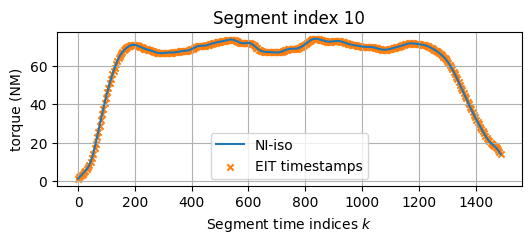

detected start idx valuestmp_ts_seg[0]=1739979698.91, times_eit[eit_start_ts]=1739979698.917
eit_start_ts=23216, eit_stop_ts=23349, diff:133
23216 diff start: -0.006999969482421875 diff end: -5.01200008392334


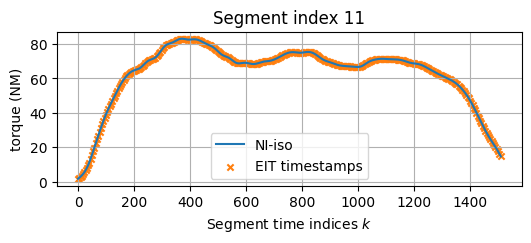

detected start idx valuestmp_ts_seg[0]=1739979751.66, times_eit[eit_start_ts]=1739979751.664
eit_start_ts=25326, eit_stop_ts=25459, diff:133
25326 diff start: -0.003999948501586914 diff end: -5.023999929428101


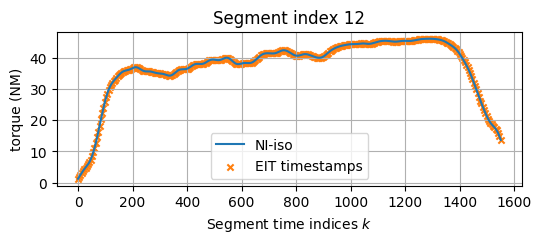

detected start idx valuestmp_ts_seg[0]=1739979806.42, times_eit[eit_start_ts]=1739979806.411
eit_start_ts=27516, eit_stop_ts=27649, diff:133
27516 diff start: 0.009000062942504883 diff end: -4.980999946594238


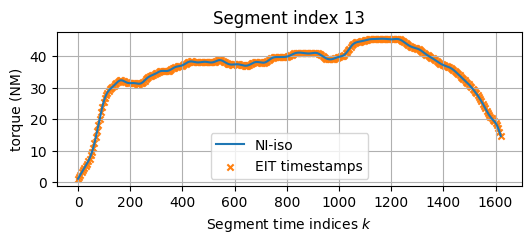

detected start idx valuestmp_ts_seg[0]=1739979860.28, times_eit[eit_start_ts]=1739979860.284
eit_start_ts=29671, eit_stop_ts=29803, diff:132
29671 diff start: -0.003999948501586914 diff end: -4.978000164031982


In [12]:
EIT, TORQUE, TS_iso, TS_eit = sync_eit_ISO_segments(
    part_path, isoforce_iso, isoforce_py
)

In [13]:
EIT.shape, TORQUE.shape, TS_iso.shape, TS_eit.shape

((4588, 16, 16), (4588,), (4588,), (4588,))

In [14]:
# times_eit, eit = load_eit_npz(part_path)
# time_py = [dt.timestamp() for dt in isoforce_py.time]

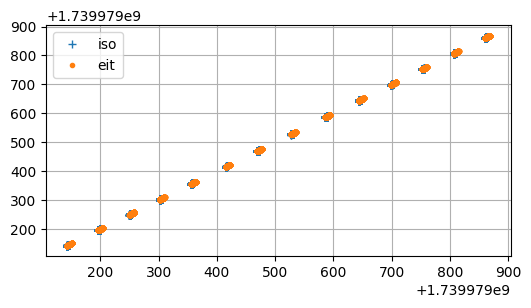

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(TS_iso, TS_iso, "+", label="iso")
plt.plot(TS_eit, TS_eit, ".", label="eit")
plt.legend()
plt.grid()
# plt.xlim([6400,6600])
plt.show()

**Export**

In [37]:
from os.path import join

From: data/raw_data/P03/
To: data/prepared_data/P03/
Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


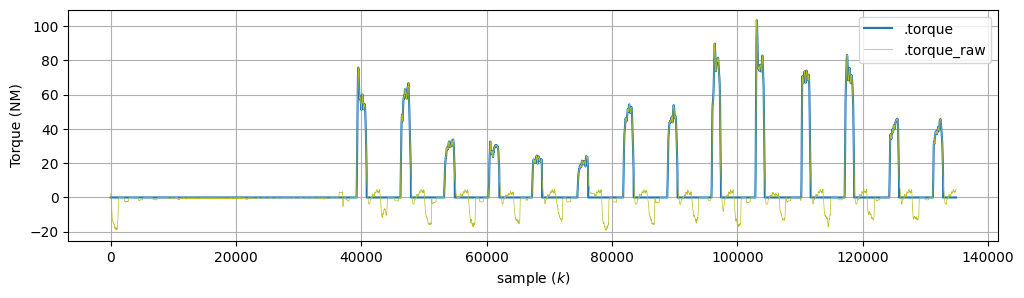

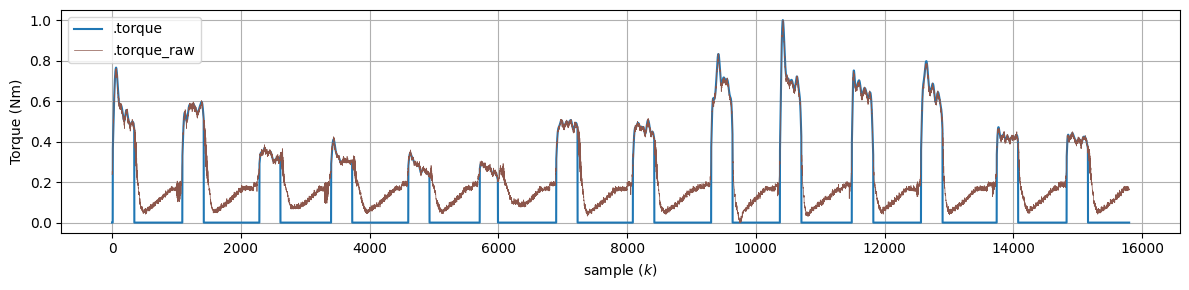

Loading eit...
Matching sequences...
detected start idx valuestmp_ts_seg[0]=1739979143.1, times_eit[eit_start_ts]=1739979143.097
eit_start_ts=982, eit_stop_ts=1115, diff:133
982 diff start: 0.003000020980834961 diff end: -5.016000032424927
detected start idx valuestmp_ts_seg[0]=1739979195.91, times_eit[eit_start_ts]=1739979195.919
eit_start_ts=3095, eit_stop_ts=3227, diff:132
3095 diff start: -0.008999824523925781 diff end: -4.999000072479248
detected start idx valuestmp_ts_seg[0]=1739979249.88, times_eit[eit_start_ts]=1739979249.891
eit_start_ts=5254, eit_stop_ts=5384, diff:130
5254 diff start: -0.010999917984008789 diff end: -4.910999774932861
detected start idx valuestmp_ts_seg[0]=1739979302.02, times_eit[eit_start_ts]=1739979302.014
eit_start_ts=7339, eit_stop_ts=7470, diff:131
7339 diff start: 0.006000041961669922 diff end: -4.9079999923706055
detected start idx valuestmp_ts_seg[0]=1739979356.01, times_eit[eit_start_ts]=1739979356.011
eit_start_ts=9499, eit_stop_ts=9630, diff:131


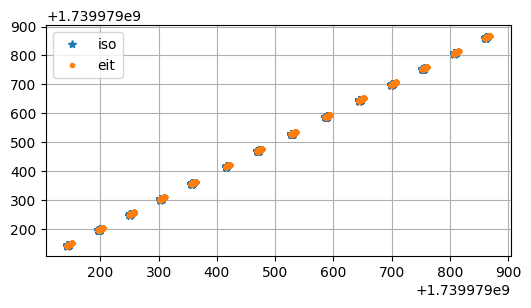

Export data (y) y


From: data/raw_data/P04/
To: data/prepared_data/P04/
Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


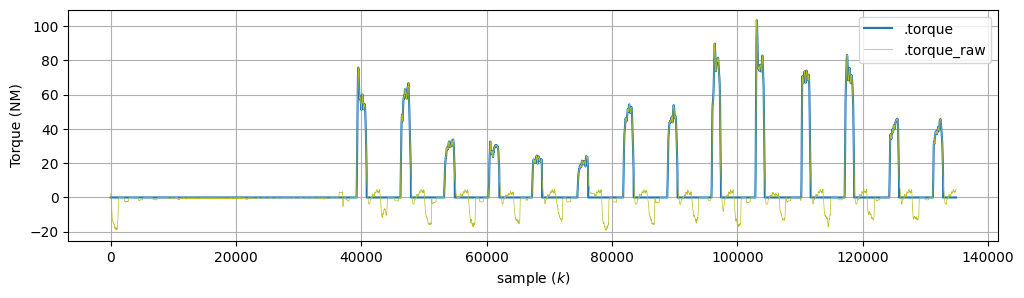

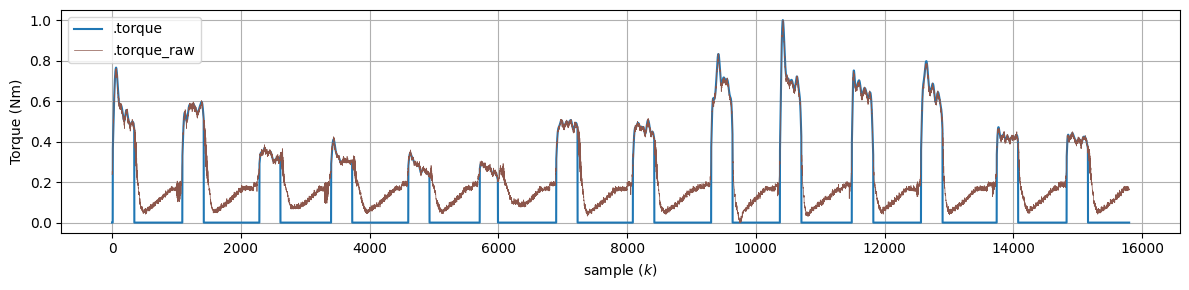

Loading eit...
Matching sequences...
detected start idx valuestmp_ts_seg[0]=1739979143.1, times_eit[eit_start_ts]=1739979143.097
eit_start_ts=982, eit_stop_ts=1115, diff:133
982 diff start: 0.003000020980834961 diff end: -5.016000032424927
detected start idx valuestmp_ts_seg[0]=1739979195.91, times_eit[eit_start_ts]=1739979195.919
eit_start_ts=3095, eit_stop_ts=3227, diff:132
3095 diff start: -0.008999824523925781 diff end: -4.999000072479248
detected start idx valuestmp_ts_seg[0]=1739979249.88, times_eit[eit_start_ts]=1739979249.891
eit_start_ts=5254, eit_stop_ts=5384, diff:130
5254 diff start: -0.010999917984008789 diff end: -4.910999774932861
detected start idx valuestmp_ts_seg[0]=1739979302.02, times_eit[eit_start_ts]=1739979302.014
eit_start_ts=7339, eit_stop_ts=7470, diff:131
7339 diff start: 0.006000041961669922 diff end: -4.9079999923706055
detected start idx valuestmp_ts_seg[0]=1739979356.01, times_eit[eit_start_ts]=1739979356.011
eit_start_ts=9499, eit_stop_ts=9630, diff:131


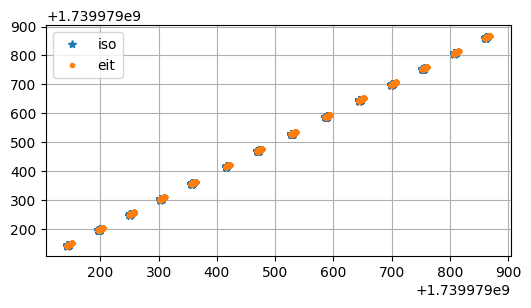

Export data (y) y


From: data/raw_data/P05/
To: data/prepared_data/P05/
Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


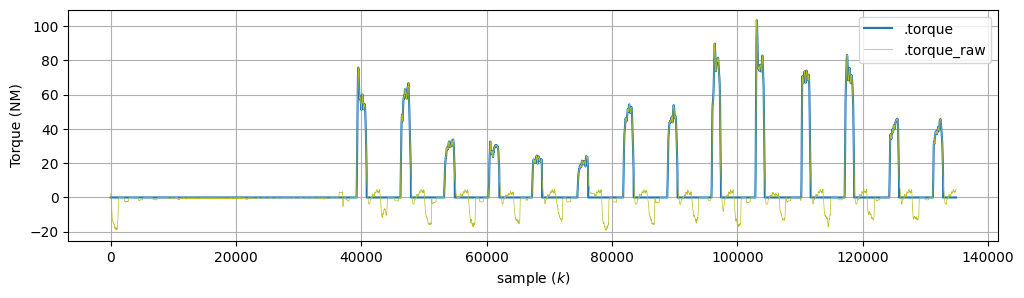

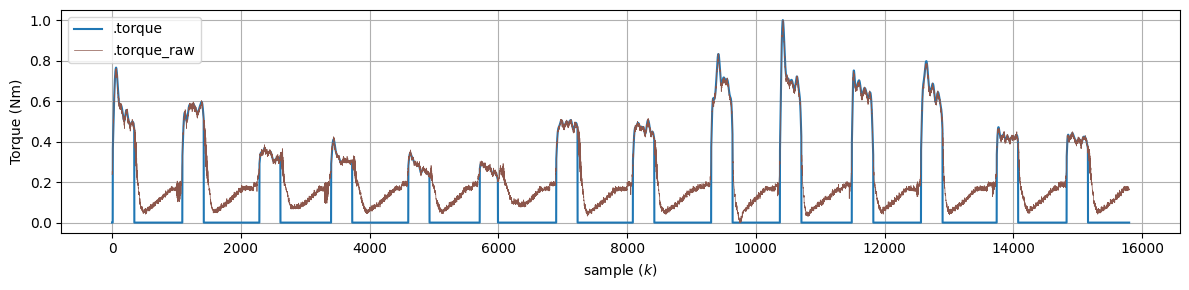

Loading eit...
Matching sequences...
detected start idx valuestmp_ts_seg[0]=1739979143.1, times_eit[eit_start_ts]=1739979143.097
eit_start_ts=982, eit_stop_ts=1115, diff:133
982 diff start: 0.003000020980834961 diff end: -5.016000032424927
detected start idx valuestmp_ts_seg[0]=1739979195.91, times_eit[eit_start_ts]=1739979195.919
eit_start_ts=3095, eit_stop_ts=3227, diff:132
3095 diff start: -0.008999824523925781 diff end: -4.999000072479248
detected start idx valuestmp_ts_seg[0]=1739979249.88, times_eit[eit_start_ts]=1739979249.891
eit_start_ts=5254, eit_stop_ts=5384, diff:130
5254 diff start: -0.010999917984008789 diff end: -4.910999774932861
detected start idx valuestmp_ts_seg[0]=1739979302.02, times_eit[eit_start_ts]=1739979302.014
eit_start_ts=7339, eit_stop_ts=7470, diff:131
7339 diff start: 0.006000041961669922 diff end: -4.9079999923706055
detected start idx valuestmp_ts_seg[0]=1739979356.01, times_eit[eit_start_ts]=1739979356.011
eit_start_ts=9499, eit_stop_ts=9630, diff:131


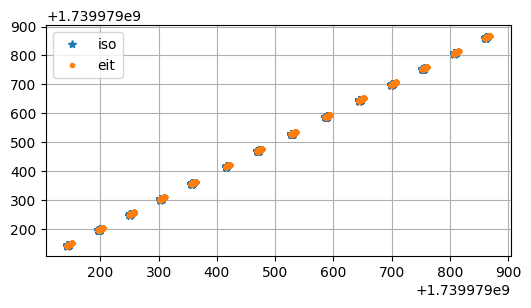

Export data (y) y


From: data/raw_data/P06/
To: data/prepared_data/P06/
Fund participant data:

Head directory: self.path='data/raw_data/P03/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/raw_data/P03/EIT_P03_raw_data_12012025140815.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/raw_data/P03/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/raw_data/P03/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/raw_data/P03/eit_raw/20250219 10.31.57/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/raw_data/P03/EIT_processed/'
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


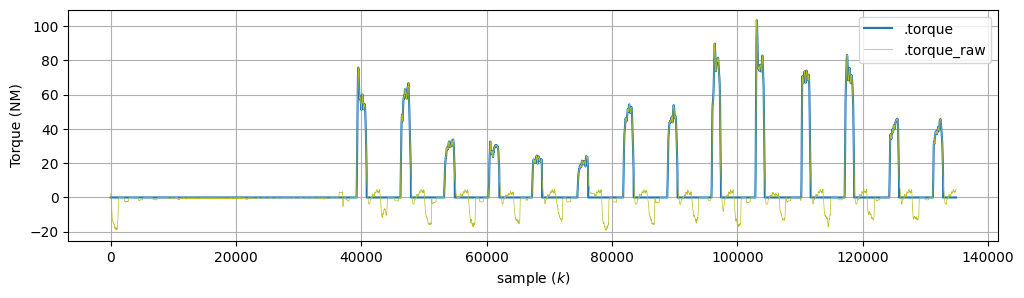

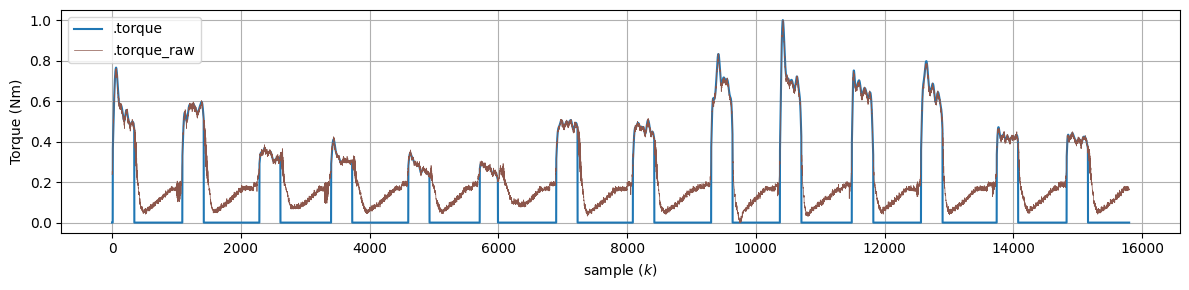

Loading eit...
Matching sequences...
detected start idx valuestmp_ts_seg[0]=1739979143.1, times_eit[eit_start_ts]=1739979143.097
eit_start_ts=982, eit_stop_ts=1115, diff:133
982 diff start: 0.003000020980834961 diff end: -5.016000032424927
detected start idx valuestmp_ts_seg[0]=1739979195.91, times_eit[eit_start_ts]=1739979195.919
eit_start_ts=3095, eit_stop_ts=3227, diff:132
3095 diff start: -0.008999824523925781 diff end: -4.999000072479248
detected start idx valuestmp_ts_seg[0]=1739979249.88, times_eit[eit_start_ts]=1739979249.891
eit_start_ts=5254, eit_stop_ts=5384, diff:130
5254 diff start: -0.010999917984008789 diff end: -4.910999774932861
detected start idx valuestmp_ts_seg[0]=1739979302.02, times_eit[eit_start_ts]=1739979302.014
eit_start_ts=7339, eit_stop_ts=7470, diff:131
7339 diff start: 0.006000041961669922 diff end: -4.9079999923706055
detected start idx valuestmp_ts_seg[0]=1739979356.01, times_eit[eit_start_ts]=1739979356.011
eit_start_ts=9499, eit_stop_ts=9630, diff:131


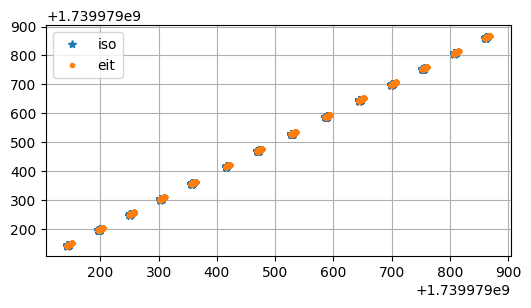

Export data (y) y


In [39]:
# perfect: 3,4,5,6

for p in [3, 4, 5, 6]:
    l_path = join("data/raw_data", "P{0:02d}/".format(p))
    s_path = join("data/prepared_data", "P{0:02d}/".format(p))
    print("From:", l_path)
    print("To:", s_path)
    try:
        os.mkdir(s_path)
    except BaseException:
        print("Already exist")
    part_path = ProcessingDir(path)  # SAVE
    protocol = Protocol(part_path.path, prints=False)  # SAVE

    DF = renderDF(part_path.isoforce_iso)
    isoforce_iso = IsoforceIso(DF, LP_filter=True)
    isoforce_iso.plot_torque()

    isoforce_py = IsoforcePy(
        part_path.isoforce_py_raw,
        protocol,
        LP_filter=True,
        over_UTC=False,
        scale_0_1=True,
    )
    isoforce_py.plot_torque()

    assert len(isoforce_iso.torque_segments.keys()) == len(
        isoforce_py.torque_segments.keys()
    )

    EIT, TORQUE, TS_iso, TS_eit = sync_eit_ISO_segments(
        part_path, isoforce_iso, isoforce_py, plotting=False
    )
    assert TS_iso.shape[0] == TS_eit.shape[0]
    print(EIT.shape, TORQUE.shape, TS_iso.shape, TS_eit.shape)

    plt.figure(figsize=(6, 3))
    plt.plot(TS_iso, TS_iso, "*", label="iso")
    plt.plot(TS_eit, TS_eit, ".", label="eit")
    plt.legend()
    plt.grid()
    plt.show()

    if input("Export data (y)") == "y":
        for i in range(EIT.shape[0]):
            np.savez(
                join(s_path, "sample_{0:06d}.npz".format(i)),
                part_path=part_path,
                EIT=EIT[i],
                TORQUE=TORQUE[i],
                TS_eit=TS_eit[i],
                TS_iso=TS_iso[i],
                protocol=protocol,
            )
    else:
        print("Skipping:", s_path)

In [41]:
for ele in np.sort(glob("data/prepared_data/P*")):
    print(ele, len(os.listdir(ele)))

data/prepared_data/P03 4588
data/prepared_data/P04 4588
data/prepared_data/P05 4588
data/prepared_data/P06 4588


**Statistics**

In [44]:
tmp = np.load("data/prepared_data/P03/sample_000000.npz", allow_pickle=True)
tmp.files

['part_path', 'EIT', 'TORQUE', 'TS_eit', 'TS_iso', 'protocol']

In [48]:
def load_data(load_Ps: list, path: str = "data/prepared_data"):
    X = list()
    Y = list()
    for P in load_Ps:
        l_path = join(path, P)
        for ele in np.sort(glob(join(l_path, "*.npz"))):
            tmp = np.load(ele, allow_pickle=True)
            X.append(tmp["EIT"])
            Y.append(tmp["TORQUE"])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


X, y = load_data(["P03", "P04", "P05", "P06"])

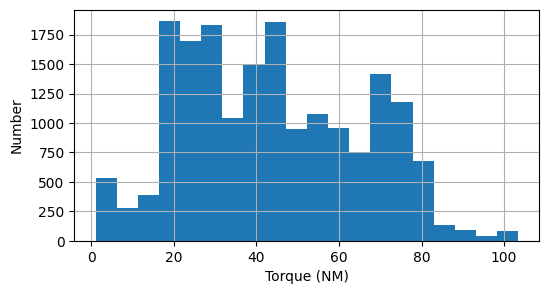

In [51]:
plt.figure(figsize=(6, 3))
plt.hist(y, bins=20)
plt.ylabel("Number")
plt.xlabel("Torque (NM)")
plt.grid()
plt.show()

**TESTING TIME SYNC#2**

In [ ]:
datetime.fromtimestamp(times_eit[2482])

In [ ]:
T_EIT, eit = load_eit_npz(part_path)

SEQ, sampled_iso = sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx=1, plotting=False
)

# T_EIT = np.array([datetime.fromtimestamp(ts) for ts in T_EIT])
# SEQ =  np.array([datetime.fromtimestamp(ts) for ts in SEQ])

In [54]:
T_EIT.shape, SEQ.shape

((34358,), (155,))

In [56]:
find_best_match(T_EIT, SEQ)

(2557, 13.390906948579936)

In [57]:
%time find_best_match(T_EIT,SEQ)

CPU times: user 31.4 s, sys: 2.41 ms, total: 31.4 s
Wall time: 31.4 s


(2557, 13.390906948579936)